## Create own word embeddings using gensim word2vec

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import gzip
import keras

Using TensorFlow backend.


In [3]:
import nltk
from nltk import numpy
from nltk import ne_chunk, pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize, PunktSentenceTokenizer
from nltk.corpus import stopwords
import gensim.models.word2vec as w2v
from gensim import logging
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as  pd
import seaborn as sns
import pickle

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#### Download corpus

In [6]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Load document files into memory for creating representation

In [11]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	#with codecs.open(filename, "r",encoding='utf-8', errors='ignore') as fdata:
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text 

#### Load own vocabulary

In [139]:
# load the vocabulary
vocab_filename = './embedding/vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

#### Clean documents

In [140]:
def select_text (data,keys):
    tokens_list = []
    for item in data:
        for i in keys:
            d = item[i] 
            d = d.encode("utf8") 
            tokens = clean_doc(d, vocab)    
             
            tokens_list.append(str(tokens))
     
    return tokens_list

In [141]:
import re
import string
# turn a doc into clean tokens

def clean_doc(doc, vocab):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    #table = string.maketrans('', '', punctuation)
    #tokens = [w.translate(table) for w in tokens]
    
    
    for w in tokens:         
        w =  re.sub('['+string.punctuation+']', '', w )       
    # filter out tokens not in vocab
    
    tokens = [w for w in tokens if w in vocab]
    tokens = ' '.join(tokens)
     
    return tokens
 

In [142]:
import json
from os import listdir
# load all docs in a directory
def process_docs(directory, vocab, is_trian):
	documents = []
	# walk through all files in the folder
	for filename in listdir(directory):
	    # create the full path of the file to open
	    path = directory + '/' + filename
	    # load the doc
	    #doc = load_doc(path)
	    with open(path, "r") as f:
	 	     doc = json.load(f)
	    #tokens_list = select_text (doc ,['description','facility','nearby'])
	    # clean doc
	    tokens_list = select_text (doc ,['description']) 
	    #tokens = clean_doc(doc[, vocab)
	    # add to list
	    documents.extend(tokens_list)
        #print(tokens_list[:5])
	return documents

### Start processing documents

In [143]:
# load all training text
hotel_docs = process_docs('./embedding/data', vocab, True)
hotel_docs[:5]

['stay Petpimarn Boutique Resort Bangkok within drive Kasetsart University IMPACT This hotel mi Temple Emerald Buddha mi Wat home one rooms featuring Complimentary wireless Internet access keeps digital programming available Bathrooms showers complimentary Conveniences include desks complimentary bottled housekeeping provided use convenient include complimentary wireless Internet access Petpimarn Boutique enjoy satisfying meal English breakfasts available daily AM AM amenities include dry front luggage Free self parking available',
 'Airport Suite Bangkok Muang located area city Don Mueang hotel good also near Don Mueang International Airport km plenty tourist attractions IT Square within Central Ramintra within Splendid service together wide range facilities provided make complain nothing stay Airport Suite Bangkok Muang fitness center stay enjoyable relaxing day whether traveling solo loved best deal finest quality spa treatment unwind rejuvenate front desk available serve assistance

In [145]:
corpus_raw = "" 
for item in hotel_docs:
    #print("Reading '{0}' ...".format(item))
    #with codecs.open(book_filename, "r", "utf-8") as book_file:
    corpus_raw += item+" "
    #print("Corpus is now {0} characters long" .format(len(corpus_raw)))
    #print()
print("Corpus is now {0} characters long" .format(len(corpus_raw)))
#print(corpus_raw[:7000])


Corpus is now 3468594 characters long


#### Load English token punctuation

In [146]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [147]:
raw_sentences = tokenizer.tokenize(corpus_raw)


In [148]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-z]"," ", raw)
    words = clean.split()
    return words

#### Chop sentence in to word list

In [149]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence)>0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [150]:
print(raw_sentences[0][:100])
print(sentence_to_wordlist(raw_sentences[0][:100]))

stay Petpimarn Boutique Resort Bangkok within drive Kasetsart University IMPACT This hotel mi Temple
['stay', 'Petpimarn', 'Boutique', 'Resort', 'Bangkok', 'within', 'drive', 'Kasetsart', 'University', 'IMPACT', 'This', 'hotel', 'mi', 'Temple']


In [151]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 479,162 tokens


## Create model

In [152]:
hotel2vec = w2v.Word2Vec(
    sg=1,
    seed=1,
    workers=multiprocessing.cpu_count(),
    size=500,
    min_count=10,
    window=7,
    sample=1e-3
)

In [153]:
hotel2vec.build_vocab(sentences)

2019-01-31 21:31:50,178 : INFO : collecting all words and their counts
2019-01-31 21:31:50,180 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-31 21:31:50,262 : INFO : collected 5131 word types from a corpus of 479162 raw words and 1 sentences
2019-01-31 21:31:50,263 : INFO : Loading a fresh vocabulary
2019-01-31 21:31:50,281 : INFO : effective_min_count=10 retains 1838 unique words (35% of original 5131, drops 3293)
2019-01-31 21:31:50,282 : INFO : effective_min_count=10 leaves 464824 word corpus (97% of original 479162, drops 14338)
2019-01-31 21:31:50,295 : INFO : deleting the raw counts dictionary of 5131 items
2019-01-31 21:31:50,298 : INFO : sample=0.001 downsamples 114 most-common words
2019-01-31 21:31:50,300 : INFO : downsampling leaves estimated 335252 word corpus (72.1% of prior 464824)
2019-01-31 21:31:50,311 : INFO : estimated required memory for 1838 words and 500 dimensions: 8271000 bytes
2019-01-31 21:31:50,313 : INFO : resetting layer

In [154]:
print(len(hotel2vec.wv.vocab))

1838


In [155]:
#training

hotel2vec.train(sentences,total_examples=len(sentences),epochs=200)

2019-01-31 21:31:56,278 : INFO : training model with 4 workers on 1838 vocabulary and 500 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-01-31 21:31:56,290 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-31 21:31:56,292 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 21:31:56,294 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 21:31:56,517 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-31 21:31:56,519 : INFO : EPOCH - 1 : training on 479162 raw words (10000 effective words) took 0.2s, 42321 effective words/s
2019-01-31 21:31:56,527 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-31 21:31:56,529 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 21:31:56,530 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 21:31:56,719 : INFO : worker thread finished; awaiting finish of 0 mor

2019-01-31 21:31:59,567 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 21:31:59,568 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 21:31:59,774 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-31 21:31:59,775 : INFO : EPOCH - 17 : training on 479162 raw words (10000 effective words) took 0.2s, 46372 effective words/s
2019-01-31 21:31:59,785 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-31 21:31:59,792 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 21:31:59,794 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 21:31:59,960 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-31 21:31:59,962 : INFO : EPOCH - 18 : training on 479162 raw words (10000 effective words) took 0.2s, 54547 effective words/s
2019-01-31 21:31:59,970 : INFO : worker thread finished; awaiting finish of 3 more threads
2019

2019-01-31 21:32:02,732 : INFO : EPOCH - 33 : training on 479162 raw words (10000 effective words) took 0.2s, 54457 effective words/s
2019-01-31 21:32:02,742 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-31 21:32:02,744 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 21:32:02,745 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 21:32:02,913 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-31 21:32:02,915 : INFO : EPOCH - 34 : training on 479162 raw words (10000 effective words) took 0.2s, 55694 effective words/s
2019-01-31 21:32:02,923 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-31 21:32:02,925 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 21:32:02,927 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 21:32:03,094 : INFO : worker thread finished; awaiting finish of 0 more threads
2019

2019-01-31 21:32:05,646 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 21:32:05,648 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 21:32:05,810 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-31 21:32:05,812 : INFO : EPOCH - 50 : training on 479162 raw words (10000 effective words) took 0.2s, 57946 effective words/s
2019-01-31 21:32:05,823 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-31 21:32:05,824 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 21:32:05,826 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 21:32:05,985 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-31 21:32:05,987 : INFO : EPOCH - 51 : training on 479162 raw words (10000 effective words) took 0.2s, 59138 effective words/s
2019-01-31 21:32:05,995 : INFO : worker thread finished; awaiting finish of 3 more threads
2019

2019-01-31 21:32:08,860 : INFO : EPOCH - 66 : training on 479162 raw words (10000 effective words) took 0.2s, 48122 effective words/s
2019-01-31 21:32:08,869 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-31 21:32:08,872 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 21:32:08,873 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 21:32:09,032 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-31 21:32:09,034 : INFO : EPOCH - 67 : training on 479162 raw words (10000 effective words) took 0.2s, 58997 effective words/s
2019-01-31 21:32:09,042 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-31 21:32:09,044 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 21:32:09,046 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 21:32:09,201 : INFO : worker thread finished; awaiting finish of 0 more threads
2019

2019-01-31 21:32:11,705 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 21:32:11,707 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 21:32:11,874 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-31 21:32:11,875 : INFO : EPOCH - 83 : training on 479162 raw words (10000 effective words) took 0.2s, 55177 effective words/s
2019-01-31 21:32:11,883 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-31 21:32:11,885 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 21:32:11,886 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 21:32:12,041 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-31 21:32:12,043 : INFO : EPOCH - 84 : training on 479162 raw words (10000 effective words) took 0.2s, 60764 effective words/s
2019-01-31 21:32:12,050 : INFO : worker thread finished; awaiting finish of 3 more threads
2019

2019-01-31 21:32:14,741 : INFO : EPOCH - 99 : training on 479162 raw words (10000 effective words) took 0.2s, 60408 effective words/s
2019-01-31 21:32:14,749 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-31 21:32:14,751 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-31 21:32:14,753 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-31 21:32:14,941 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-31 21:32:14,943 : INFO : EPOCH - 100 : training on 479162 raw words (10000 effective words) took 0.2s, 50314 effective words/s
2019-01-31 21:32:14,944 : INFO : training on a 47916200 raw words (1000000 effective words) took 18.7s, 53579 effective words/s


(1000000, 47916200)

In [156]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [157]:
filename ="hotel2vec_desc.w2v"

In [158]:
#save model (binary)
hotel2vec.save(os.path.join("trained",filename ))

2019-01-31 21:32:28,891 : INFO : saving Word2Vec object under trained/hotel2vec_desc.w2v, separately None
2019-01-31 21:32:28,893 : INFO : not storing attribute vectors_norm
2019-01-31 21:32:28,895 : INFO : not storing attribute cum_table
2019-01-31 21:32:28,936 : INFO : saved trained/hotel2vec_desc.w2v


## Load model

In [159]:
hotel2vec = w2v.Word2Vec.load(os.path.join("trained", filename))

2019-01-31 21:32:30,884 : INFO : loading Word2Vec object from trained/hotel2vec_desc.w2v
2019-01-31 21:32:30,920 : INFO : loading vocabulary recursively from trained/hotel2vec_desc.w2v.vocabulary.* with mmap=None
2019-01-31 21:32:30,921 : INFO : loading wv recursively from trained/hotel2vec_desc.w2v.wv.* with mmap=None
2019-01-31 21:32:30,923 : INFO : setting ignored attribute vectors_norm to None
2019-01-31 21:32:30,925 : INFO : loading trainables recursively from trained/hotel2vec_desc.w2v.trainables.* with mmap=None
2019-01-31 21:32:30,926 : INFO : setting ignored attribute cum_table to None
2019-01-31 21:32:30,929 : INFO : loaded trained/hotel2vec_desc.w2v


In [160]:
#create matrix representation 2D
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [161]:
all_word_vectors_matrix = hotel2vec.wv.syn0

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [162]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [163]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
                (word, all_word_vectors_matrix_2d[hotel2vec.wv.vocab[word].index])
                for word in hotel2vec.wv.vocab
       
        ]
        
    ],
    columns= ["word", "x", "y"]

)

In [164]:
points.head(10)

word          x          y
0     limited   1.672884 -57.428547
1        Leaf   0.418889  18.745623
2      Savage -11.757586  22.136112
3    Boutique   6.652567 -20.966507
4      Saphan  -0.460165 -37.576576
5       Sugar -12.111789  10.657574
6  facilities   9.468491 -28.507401
7       Lodge  10.587101 -39.030670
8    appetite  10.102147   4.174364
9   Hotspring  -3.703822  13.456757

In [165]:
sns.set_context("poster")

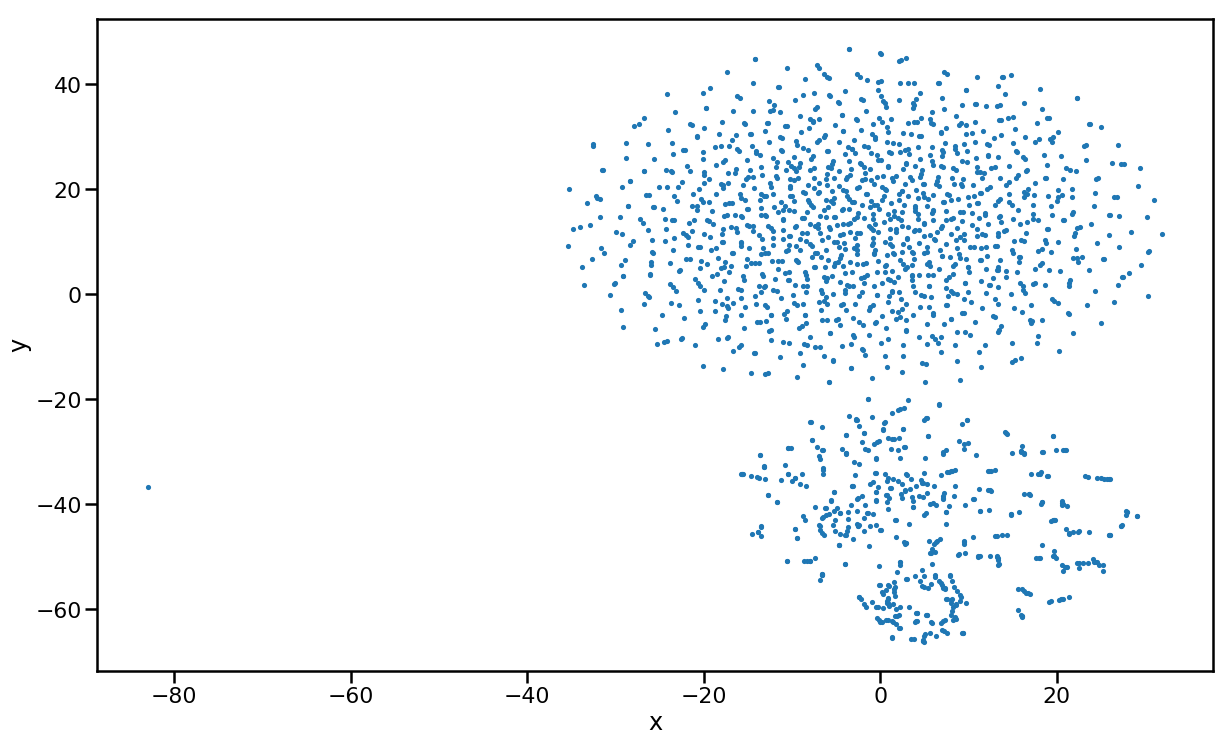

In [166]:
points.plot.scatter("x","y",s=10,figsize=(20,12))

In [167]:
def plot_region(x_bounds,y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    ax = slice.plot.scatter("x", "y",s=35,figsize=(20,12))
    for i, point in slice.iterrows():
        ax.text(point.x+0.005, point.y+0.005, point.word, fontsize=11)

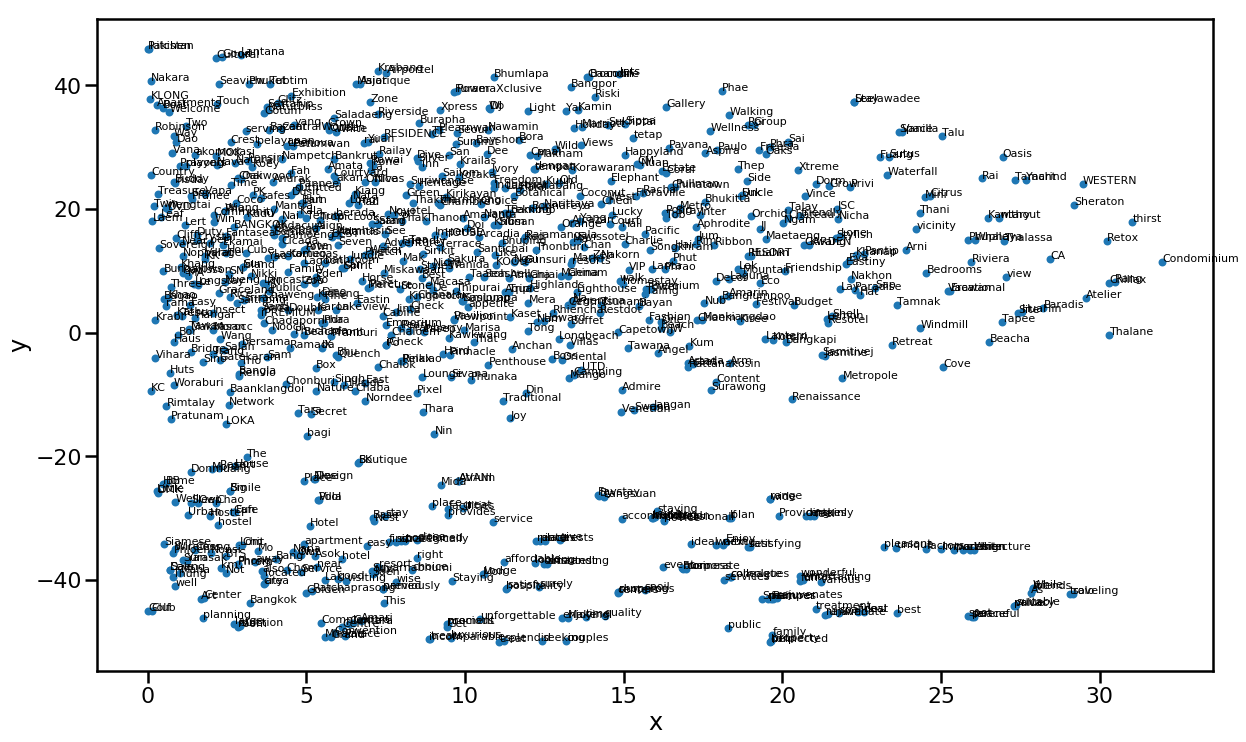

In [168]:
plot_region(x_bounds=(0,100), y_bounds=(-50,50))

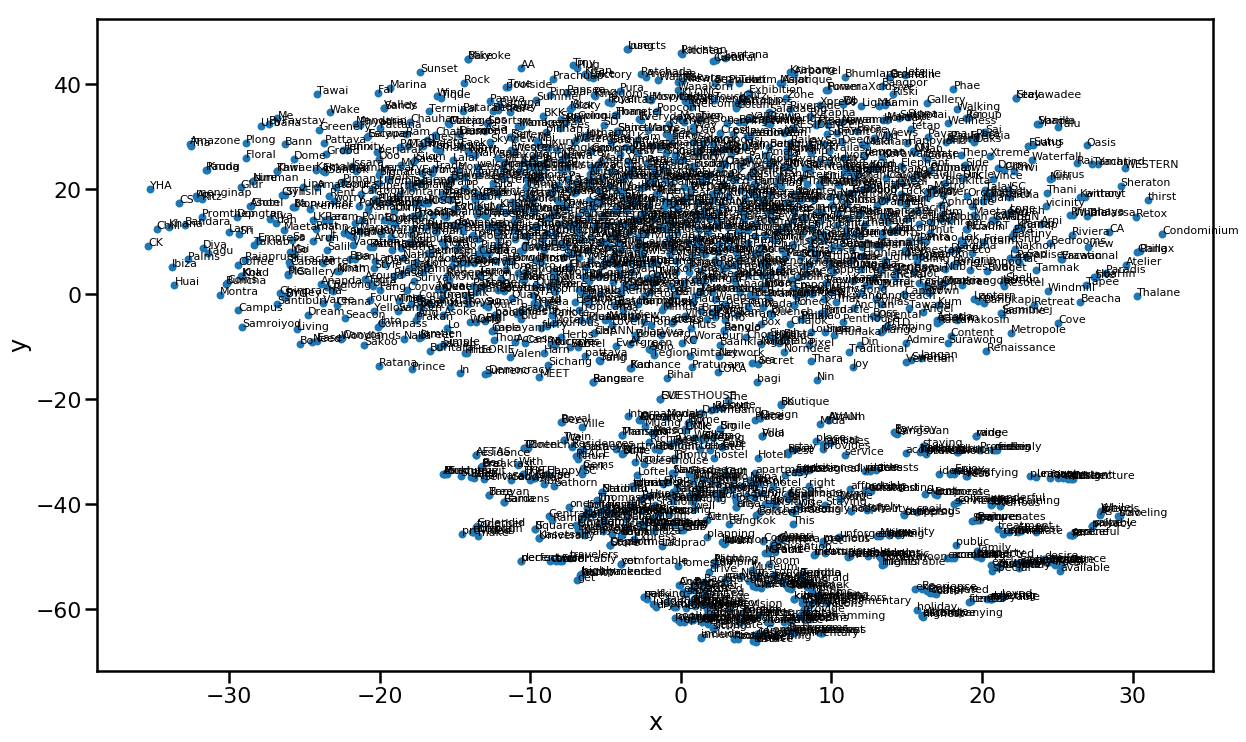

In [169]:
plot_region(x_bounds=(-50, 2000), y_bounds=(-100,2000))

## Find similarity

In [170]:
hotel2vec.most_similar("km")

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-01-31 21:33:31,030 : INFO : precomputing L2-norms of word weight vectors


[('BTS', 0.717814028263092),
 ('tourist', 0.6987690329551697),
 ('plenty', 0.6928702592849731),
 ('Phrom', 0.690683126449585),
 ('Nonsi', 0.6883622407913208),
 ('attractions', 0.6850756406784058),
 ('Chit', 0.6812716722488403),
 ('Not', 0.6774590015411377),
 ('Stadium', 0.6771640181541443),
 ('hostels', 0.6688405275344849)]

In [171]:
hotel2vec.most_similar("Samui")

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Manok', 0.15241976082324982),
 ('wide', 0.14000409841537476),
 ('hospitality', 0.13826729357242584),
 ('waiting', 0.13212813436985016),
 ('shopping', 0.1289607584476471),
 ('centers', 0.12685398757457733),
 ('Great', 0.12398165464401245),
 ('holiday', 0.12380566447973251),
 ('pampered', 0.1229107677936554),
 ('numerous', 0.12283369153738022)]

In [172]:
hotel2vec.most_similar("Phuket")

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Tubtim', 0.1408241093158722),
 ('Seaview', 0.1396687775850296),
 ('Adults', 0.12665718793869019),
 ('Sivana', 0.1247742548584938),
 ('Citrus', 0.12449150532484055),
 ('Kart', 0.11805465072393417),
 ('Maenam', 0.11669003963470459),
 ('Chateau', 0.11656996607780457),
 ('Thara', 0.11415570974349976),
 ('nearby', 0.11353720724582672)]

In [173]:
hotel2vec.similar_by_word("near")

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('Chom', 0.6203288435935974),
 ('km', 0.6038334369659424),
 ('hostels', 0.600498616695404),
 ('Min', 0.5962347984313965),
 ('Suvarnabhumi', 0.581788182258606),
 ('Phrom', 0.5691582560539246),
 ('Base', 0.561538577079773),
 ('following', 0.5583275556564331),
 ('hotels', 0.544858992099762),
 ('apartments', 0.5440230965614319)]

In [174]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = hotel2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [175]:
nearest_similarity_cosmul("Ratchada", "Bangkok", "Phuket")
nearest_similarity_cosmul("Phuket", "Patong", "Lipa")

Ratchada is related to Bangkok, as Sanctuary is related to Phuket
Phuket is related to Patong, as Sriracha is related to Lipa


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


'Sriracha'

In [186]:
hotel2vec = w2v.Word2Vec.load(os.path.join("trained", filename))

2019-02-01 19:11:18,278 : INFO : loading Word2Vec object from trained/hotel2vec_desc.w2v
2019-02-01 19:11:18,322 : INFO : loading vocabulary recursively from trained/hotel2vec_desc.w2v.vocabulary.* with mmap=None
2019-02-01 19:11:18,325 : INFO : loading wv recursively from trained/hotel2vec_desc.w2v.wv.* with mmap=None
2019-02-01 19:11:18,326 : INFO : setting ignored attribute vectors_norm to None
2019-02-01 19:11:18,328 : INFO : loading trainables recursively from trained/hotel2vec_desc.w2v.trainables.* with mmap=None
2019-02-01 19:11:18,332 : INFO : setting ignored attribute cum_table to None
2019-02-01 19:11:18,337 : INFO : loaded trained/hotel2vec_desc.w2v


In [187]:
vector = hotel2vec.wv['Bangkok'] 
vector

array([-0.09551388,  0.10433007, -0.27360544, -0.1600596 ,  0.32167506,
        0.37944564,  0.04265026, -0.1722091 , -0.16751388, -0.02659709,
       -0.00531544,  0.10256881,  0.23113976, -0.06979574,  0.0692481 ,
       -0.19403307,  0.11006643,  0.03032536, -0.07253387, -0.11559737,
        0.04077892,  0.21589115, -0.2008373 , -0.25062612,  0.00764337,
       -0.0102559 , -0.17456967, -0.05503085, -0.29101986, -0.05396984,
        0.09680843, -0.15285756,  0.08194181,  0.12774518,  0.10127418,
        0.07659121, -0.05184326,  0.06958826,  0.25731716, -0.08835093,
       -0.3709921 ,  0.06895206,  0.37033477,  0.08446357,  0.05900777,
        0.05758455,  0.02958846, -0.14303458,  0.12593342, -0.16259259,
       -0.4813546 ,  0.06369792,  0.16786012,  0.21980153,  0.25708684,
        0.25161982, -0.5677863 ,  0.30967268,  0.05940874,  0.17134097,
       -0.14526229, -0.24396624, -0.01212531, -0.0674179 ,  0.021656  ,
       -0.0663019 , -0.2730356 ,  0.07946386,  0.25032204,  0.05

#### Save to txt file as glove.txt

In [203]:
filename2 = 'hotel_w2v.txt'
hotel2vec.wv.save_word2vec_format(os.path.join("trained", filename2))

2019-02-01 19:31:39,002 : INFO : storing 1838x500 projection weights into trained/hotel_w2v.txt


In [176]:
from gensim.models import KeyedVectors

In [204]:
filename2 = 'hotel_w2v.txt'
tmp_file_name = '.tmp.txt'
word2vec_model_file_name = 'trained/'+filename2
glove_output = 'hotel_w2v_glove.txt'
f_out = open(glove_output,"w")
for _ in range(2):
    try:
        with open(word2vec_model_file_name) as word2vec_model_file:
            i = 0
            for r in word2vec_model_file:
                if 0 < i:
                    if i < 5:
                        print(r.strip())
                    #print(r.strip())
                    f_out.write(r.strip())
                    

                i += 1

        break
    except UnicodeDecodeError:
        word2vec_model_file_name = tmp_file_name
        KeyedVectors.load_word2vec_format(args.word2vec, binary=True).save_word2vec_format(word2vec_model_file_name)

stay 0.03185134 0.30842072 -0.015216113 -0.22557 -0.003940718 0.44198224 0.01418591 -0.26888293 0.29643264 -0.25396392 -0.16744709 0.10891738 0.2832734 0.10479527 -0.054835454 0.079646625 0.16163144 -0.10429487 0.24347955 0.078462996 0.20630103 -0.08199148 -0.087982506 0.18341371 -0.16366704 0.10742768 -0.15196511 0.014649165 -0.23712532 -0.1878673 -0.22334279 -0.16675453 -0.02543552 0.50231683 0.1457473 -0.028596247 -0.17092378 -0.11183221 -0.2528938 0.21059065 0.0138444025 0.14455523 0.13586633 -0.09849319 0.31201467 0.117857926 0.07891507 0.18416655 0.086676955 0.009635702 -0.48990223 -0.3132728 0.10682103 0.22803213 0.10544809 -0.041962504 -0.10013072 0.060672306 -0.087249525 0.21121119 -0.089887284 0.02822587 -0.20866665 0.03078518 0.029884664 -0.12069477 -0.0011853827 0.13128293 0.19778173 -0.07836599 -0.32314602 -0.040945265 0.30676073 -0.07758132 -0.13559441 0.22661798 -0.07727725 -0.08076717 0.16328035 0.1362109 -0.092284285 0.2756881 0.12507585 0.0031907845 -0.19559936 0.2043

## Use glove  instead of word2vec

https://medium.com/@japneet121/word-vectorization-using-glove-76919685ee0b

In [205]:
#importing the glove library
from glove import Corpus, Glove
# creating a corpus object
corpus = Corpus() 

In [206]:
#training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(sentences, window=10)

In [207]:
#creating a Glove object which will use the matrix created in the above lines to create embeddings
#We can set the learning rate as it uses Gradient Descent and number of components
glove = Glove(no_components=50, learning_rate=0.05)

In [208]:
glove.fit(corpus.matrix, epochs=500, no_threads=4, verbose=True)

Performing 500 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoc

In [209]:
glove.add_dictionary(corpus.dictionary)
glove.save('hotel_glove.model')

In [210]:
myglove = glove.load('hotel_glove.model')

In [211]:
myglove.dictionary['Bangkok'] 
 

4

In [212]:
glove_array = myglove.word_vectors[myglove.dictionary['Bangkok'] ]
len(myglove.dictionary)

5131

In [213]:
glove_array

array([ 0.79670331, -0.13705896,  0.13541942, -0.01399775, -0.53952273,
        0.64371409, -0.40597482,  0.60108973,  0.95489128,  0.38511367,
       -0.50808771, -0.06605783, -0.74162718,  0.02102163, -0.58269431,
       -0.72242462,  0.03412324, -0.24887194,  0.36528252, -0.15648966,
       -0.18249046,  0.20926018, -0.04853742, -0.04830727,  0.36759301,
       -0.06526095,  0.20907089, -0.12149545, -0.13099488, -0.44415866,
       -0.32225327, -0.50647417, -0.08796065,  0.11866885,  0.03977978,
       -0.16571436, -0.7890389 ,  0.0485255 , -0.31238445, -0.67813317,
        0.44983334, -0.54527653, -0.54530236, -0.39756465,  0.44048396,
       -0.38275293,  0.64000107, -1.49239288, -0.27515339, -0.216538  ])

In [214]:
#save to txt file

filename3 = 'hotel_glove.txt'
f = open(filename3,"wt")
#print(myglove.dictionary)
for k in myglove.dictionary:
     
    f.write(k)
    f.write(' ')
    v = myglove.word_vectors[myglove.dictionary[k] ]
    
     
    for i in v:
        f.write('%f'%(i))
        f.write(' ')
    f.write('\n')
    
f.close()
    

In [215]:
!ls

1512.01712v1 (1).pdf          glove.6B.200d.txt
Abstractive-Summarization     glove.6B.300d.txt
Archive.zip                   glove.6B.50d.txt
Bangkok.csv                   glove.6B.zip
ChiangMai.csv                 glove_hotel2vec_desc.w2v.txt
Chiang_Mai.csv                hotel_glove.model
Chonburi.csv                  hotel_glove.txt
Desc and Nearby               hotel_w2v_glove.txt
Extractive-Text-Summarization myglove.txt
Krabi.csv                     numberbatch-en-17.02.txt.gz
Phuket.csv                    recurrent-neural-networks
PrachuapKhiriKhan.csv         test_word_embeddings.ipynb
SuratTani.csv                 train.ipynb
SuratThani.csv                trained
__MACOSX                      traveloka
embedding                     vocabulary-embedding.ipynb
glove-python                  word2vec.ipynb
glove.6B.100d.txt             word2vec2.ipynb
